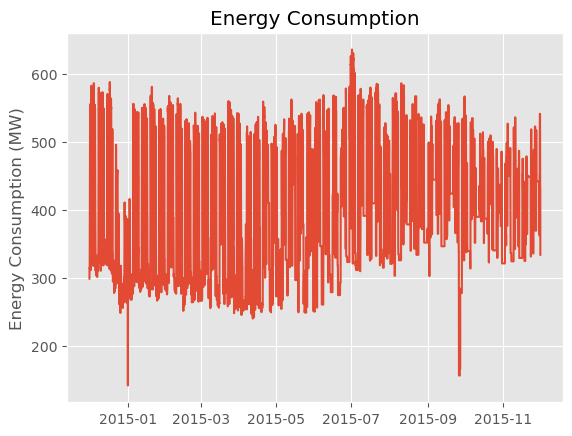

In [2]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Set Plotting Styles
plt.style.use('ggplot')


# Read the data from CSV file
newData = pd.read_csv("Office_Garman.csv", index_col="timestamp", parse_dates=True)
# Remove duplicate entries
newData = newData.drop_duplicates()
# Set the frequency to hourly
newData = newData.asfreq('H')
# Fill missing values using forward fill method
newData = newData.fillna(method='ffill')

# Visualizing Energy Consumption Data
plt.plot(newData.index, newData['Office_Garman'])
plt.title('Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.show()

# Define the split date
split_date = '2015-09-30'

# Split the data into training and testing sets
train = newData.loc[:split_date]
test = newData.loc[split_date:]



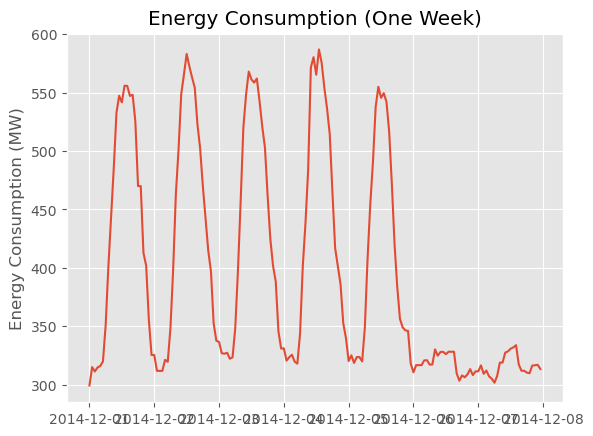

In [4]:
WEEK_END_INDEX = 7*24
plt.plot(newData.index[:WEEK_END_INDEX], newData['Office_Garman'][:WEEK_END_INDEX])
plt.title('Energy Consumption (One Week)')
plt.ylabel('Energy Consumption (MW)')
plt.show()

/var/folders/p5/4n4tz9b556x0wctr33bl1jkh0000gp/T/ipykernel_8357/2887371973.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['WeekOfYear'] = df['Date'].dt.weekofyear


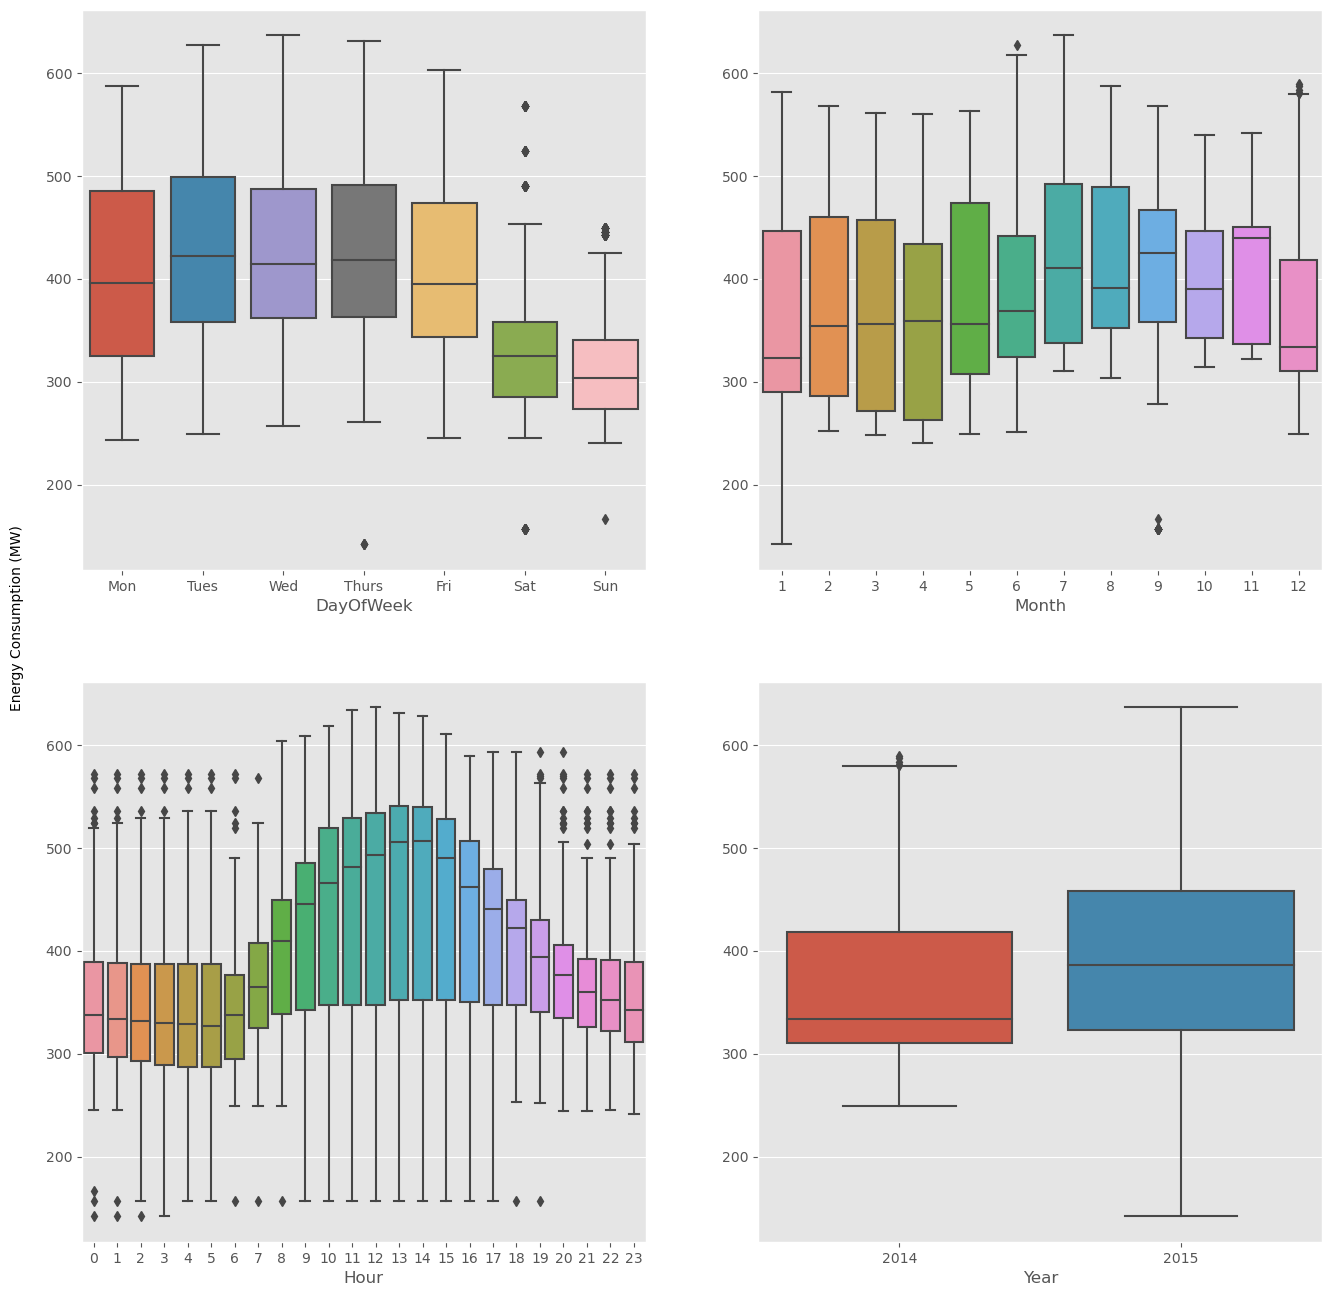

In [7]:
# Breking down DatetimeIndex into separate features 
# so we can look at some of these patterns a little more closely

def create_features(df):
    df['Date'] = df.index
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    df.drop('Date', axis=1, inplace=True)
    return df
newData = create_features(newData)
fig, axes = plt.subplots(2, 2, figsize=(16,16))
# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=newData.DayOfWeek, y=newData.Office_Garman, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')
# Month of Year
g = sns.boxplot(x=newData.Month, y=newData.Office_Garman, ax=axes[0][1])
g.set_ylabel('')
# Hour of Day
g = sns.boxplot(x=newData.Hour, y=newData.Office_Garman, ax=axes[1][0])
g.set_ylabel('')
# Year
g = sns.boxplot(x=newData.Year, y=newData.Office_Garman, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(newData['Office_Garman'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -11.660973171965004
p-value: 1.9338052604326435e-21


The p-value is less than 0.05, hence the null hypothesis of ADF test is rejected. The ts does not have a unit root, hence it is stationary. 

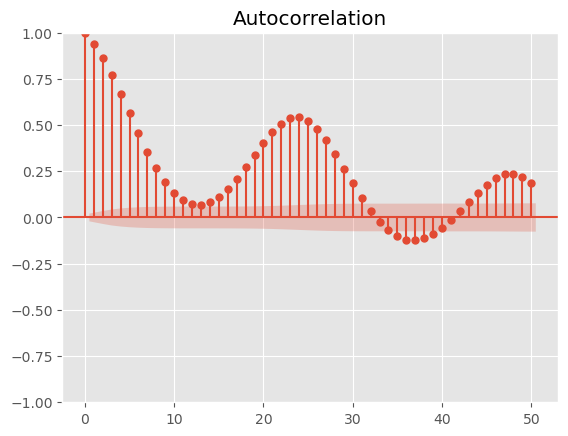

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(newData['Office_Garman'], lags=50)
plt.show()

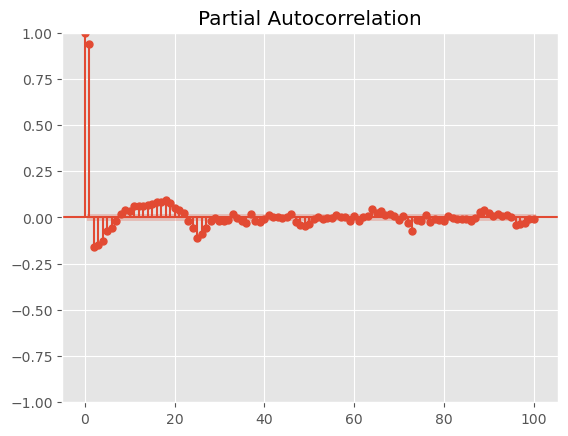

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(newData['Office_Garman'], lags=100)
plt.show()

### one-step forecasting approach using a simple AR(1) model
Forecasts will be generated using a one-step approach. This approach forecasts the value for the next time step in the series. The forecasted value is stored in a list. Once an actual value has been observed for the next time step, this value is incorporated into the time series. The model is then retrained and used to predict the value for the next unobserved time step. This process is repeated over a user-identified window of time.

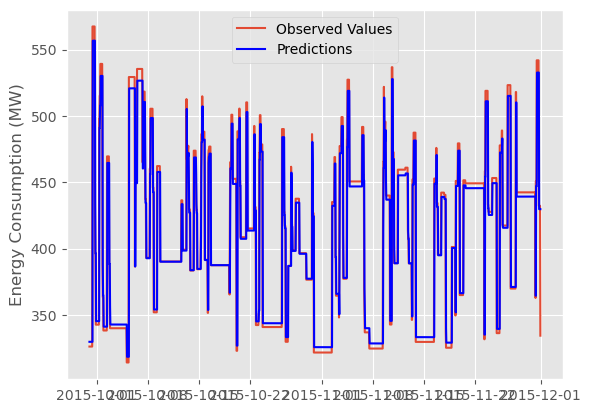

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

train_series = newData.loc[(newData.index >= datetime(2014, 12, 1)) & (newData.index < datetime(2015, 9, 30)), 'Office_Garman']
test_series = newData.loc[(newData.index >= datetime(2015, 9, 30)), 'Office_Garman']

preds = []
history = [x for x in train_series]

for t in range(len(test_series)):
    model = ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify steps=1 to forecast a single value
    preds.append(output[0])  # Use output[0] directly without indexing
    history.append(test_series[t])

pred_series = pd.Series(preds, index=test_series.index)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(test_series, label='Observed Values')
plt.plot(pred_series, color='blue', label='Predictions')
plt.title('ARIMA (1,0,0)')
plt.legend()
plt.ylabel('Energy Consumption (MW)')
plt.show()


In [34]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(test_series, pred_series)

# Calculate MAPE
mape = mean_absolute_percentage_error(test_series, pred_series)

# Calculate RMSE
rmse = mean_squared_error(test_series, pred_series, squared=False)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)


MAE: 9.543891660521362
MAPE: 0.022529734499112674
RMSE: 25.47011042276653


## need to try SARIMA model with a seasonality of 24 and a value of 1 for all available parameters related to autoregression, moving average, and differencing.

# SAR model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94371D+00    |proj g|=  1.73196D-01


 This problem is unconstrained.



At iterate    5    f=  4.85204D+00    |proj g|=  1.86795D-02

At iterate   10    f=  4.77354D+00    |proj g|=  1.72517D-02

At iterate   15    f=  4.76574D+00    |proj g|=  2.46293D-03

At iterate   20    f=  4.76472D+00    |proj g|=  7.91231D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     25      1     0     0   5.219D-06   4.764D+00
  F =   4.7643873650349322     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


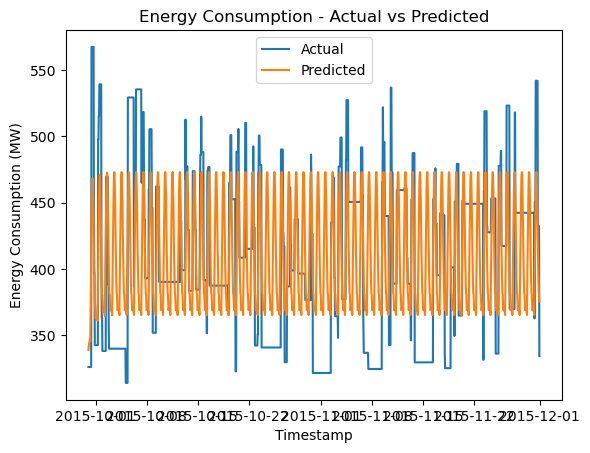

MAE: 46.28475949612657
MAPE: 0.11724835216436168
RMSE: 58.667390377081716


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Read the data from CSV file
newData = pd.read_csv("Office_Garman.csv", index_col="timestamp", parse_dates=True)
# Remove duplicate entries
newData = newData.drop_duplicates()
# Set the frequency to hourly
newData = newData.asfreq('H')
# Fill missing values using forward fill method
newData = newData.fillna(method='ffill')

# Define the split date
split_date = '2015-09-30'

# Split the data into training and testing sets
train = newData.loc[:split_date]
test = newData.loc[split_date:]

# Fit the SAR model
model = SARIMAX(train['Office_Garman'], order=(1, 0, 0), seasonal_order=(1, 1, 1, 24))
result = model.fit()

# Predict on the test set
predictions = result.get_forecast(steps=len(test))
predicted_values = predictions.predicted_mean

# Calculate evaluation metrics
mae = mean_absolute_error(test['Office_Garman'], predicted_values)
mape = mean_absolute_percentage_error(test['Office_Garman'], predicted_values)
rmse = np.sqrt(mean_squared_error(test['Office_Garman'], predicted_values))

# Visualize the predicted values and the actual values
plt.plot(test.index, test['Office_Garman'], label='Actual')
plt.plot(test.index, predicted_values, label='Predicted')
plt.title('Energy Consumption - Actual vs Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)


# SAR model with one-step prediction approach